<a href="https://colab.research.google.com/github/henkwymeersch/AutoencoderFiber/blob/master/AutoEncoderFiber.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auto-encoder for a memoryless fiber-optical channel

This script uses an auto-encoder (AE) for end-to-end learning of a non-linear memoryless fiber channel. The determines a good constellation and a good receiver. The achievable information rate is also computed. 

The system is of the form:
$$
x_{k+1}=x_k \exp (j \gamma L / K |x_k|^2) + n_k, k=0,..,K-1
$$
where $x_0$ is the input (a complex symbol), $\gamma$ is the fiber nonlinearity parameter (typically around 1.2), $L$ is the fiber length, and $K$ is the number of amplification stages. The channel output is $x_K$. Finally, $n_k$ is white Gaussian noise. 


This code was is based on the paper

Shen Li, Christian Häger, Nil Garcia, and Henk Wymeersch, "Achievable Information Rates for Nonlinear Fiber Communication via End-to-end Autoencoder Learning," in *Proc. European Conference on Optical Communication* (2018) [arXiv:1804.07675](https://arxiv.org/pdf/1804.07675.pdf). 

The code was written by Christian Häger. Parts were provided by Shen Li. Integration and polishing by Henk Wymeersch. 

Remaining issues:
*   returns NaN for too high input power



In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import math
import time
import sys

In [0]:
def tf_print(tmp_var):
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    print(sess.run(tmp_var))


In [200]:
## START: these are the main parameters to set
P_in_dBm=0              # input power in dBm
gamma = 0            # fiber nonlinearity (set to 0 zero for AWGN or 1.27 for a nonlinear channel)
M = 16                  # constellation size

# main network parameters and optimization parameters (to be modified for performance improvements)
neurons_per_layer = 50 
tx_layers = 2
rx_layers = 3
learning_rate = 0.001
iterations = 20000
stacks = 20
minibatch_size = stacks*M
## END: these are the main parameters to set


# derived channel parameters
channel_uses = 2 # this should be 2: the fiber code will break otherwise
assert(channel_uses==2), "channel uses should be 2"
L=5000             # fiber total length
K=50              # number of amplification stages
sigma = 3.8505e-4*np.sqrt(2)  # N0= h*v*nsp*(G-1) sigma**2 = BW*N0 
sigma2tot=K*sigma**2
P_in=10**(P_in_dBm/10)*0.001
Ess=np.sqrt(P_in)
SNR=Ess**2/(sigma2tot)
SNR_dB=10*np.log(SNR)

42.113492589878014


In [0]:
#=====================================================#
# Define the components of the computation graph
#=====================================================#

# transmitter
W_tx = {}
b_tx = {}
for NN in range(tx_layers):
    if NN == 0:
        in_neurons = M
    else:
        in_neurons = neurons_per_layer
    if NN == tx_layers - 1:
        out_neurons = channel_uses
    else:
        out_neurons = neurons_per_layer
    W_tx[NN] = tf.Variable(tf.random_normal([in_neurons, out_neurons]))
    b_tx[NN] = tf.Variable(tf.random_normal([1, out_neurons]))
        
# receiver
W_rx = {}
b_rx = {}
for NN in range(rx_layers):
    if NN == 0:
        in_neurons = channel_uses+1
    else:
        in_neurons = neurons_per_layer
    if NN == rx_layers - 1:
        out_neurons = M
    else:
        out_neurons = neurons_per_layer
    W_rx[NN] = tf.Variable(tf.random_normal([in_neurons, out_neurons]))
    b_rx[NN] = tf.Variable(tf.random_normal([1, out_neurons]))  

# the encoder
def encoder(x):
    for NN in range(tx_layers-1):
        x = tf.nn.tanh(tf.matmul(x, W_tx[NN]) + b_tx[NN])
    x = tf.matmul(x, W_tx[tx_layers-1]) + b_tx[tx_layers-1]
    return x

# the decoder
def decoder(x):
    for NN in range(rx_layers-1):
        x = tf.nn.tanh(tf.matmul(x, W_rx[NN]) + b_rx[NN])
    x = tf.nn.softmax(tf.matmul(x, W_rx[rx_layers-1]) + b_rx[rx_layers-1])
    return x

# the non-dispersive fiber channel  
def fiber_channel(x):
    xr=x[:,0]
    xi=x[:,1]
    for segments in range(1,K+1):               
        s=gamma*(xr**2+xi**2)*L/K        
        xr=xr*tf.cos(s)-xi*tf.sin(s)
        xi=xi*tf.cos(s)+xr*tf.sin(s)
        xr=tf.add(xr,tf.random_normal(tf.shape(xr), mean=0.0, stddev=sigma))
        xi=tf.add(xi,tf.random_normal(tf.shape(xi), mean=0.0, stddev=sigma))        
    z=tf.stack([xr,xi,xr**2+xi**2]) 
    z=tf.transpose(z) 
    return z

# average transmit power constraint
def normalization(x): # E[|x|^2] = Es
    return Ess*x / tf.sqrt(2*tf.reduce_mean(tf.square(x)))

In [0]:
#=====================================================#
# build the computation graph
#=====================================================#
X_tilde = tf.placeholder('float', [minibatch_size, M]) # one-hot vectors
X1=encoder(X_tilde)
X = normalization(X1) # minibatch_size x channel_uses
Y = fiber_channel(X)
Z = decoder(Y)
epsilon = 0.000001
loss = -tf.reduce_mean(X_tilde*tf.log(Z+epsilon))
MI=(np.log(M)-loss)/np.log(2)
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

In [203]:
#=====================================================#
# parameter training
#=====================================================#
start_time = time.time()
unitmatrix = np.eye(M)  
training_set = np.tile(unitmatrix, [stacks, 1])
init_op = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init_op)
MI_tmp=0
totalloss=[]
for i in range(1, iterations+1):
    _, loss_tmp, MI_tmp = sess.run([train, loss, MI], feed_dict={X_tilde: training_set})
    totalloss=np.append(totalloss, loss_tmp)
    if i%1000==0 or i==1:
        print('iter ', i, ': loss = ', loss_tmp, '; Mutual information [bits] = ', MI_tmp)        
elapsed = time.time() - start_time
print("{0:.2f} seconds".format(elapsed))

iter  1 : loss =  0.61487466 ; Mutual information [bits] =  3.1129234
iter  1000 : loss =  0.09702438 ; Mutual information [bits] =  3.8600233
iter  2000 : loss =  0.07483093 ; Mutual information [bits] =  3.8920417
iter  3000 : loss =  0.06772667 ; Mutual information [bits] =  3.902291
iter  4000 : loss =  0.06093725 ; Mutual information [bits] =  3.9120862
iter  5000 : loss =  0.06018138 ; Mutual information [bits] =  3.9131765
iter  6000 : loss =  0.051616617 ; Mutual information [bits] =  3.9255328
iter  7000 : loss =  0.048527546 ; Mutual information [bits] =  3.9299896
iter  8000 : loss =  0.04389426 ; Mutual information [bits] =  3.9366739
iter  9000 : loss =  0.045841657 ; Mutual information [bits] =  3.9338644
iter  10000 : loss =  0.040386204 ; Mutual information [bits] =  3.941735
iter  11000 : loss =  0.040907297 ; Mutual information [bits] =  3.940983
iter  12000 : loss =  0.037628494 ; Mutual information [bits] =  3.9457135
iter  13000 : loss =  0.050574582 ; Mutual infor

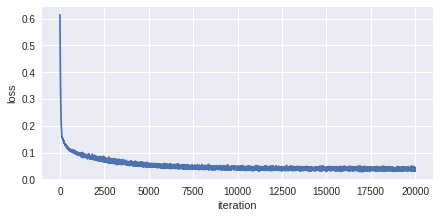

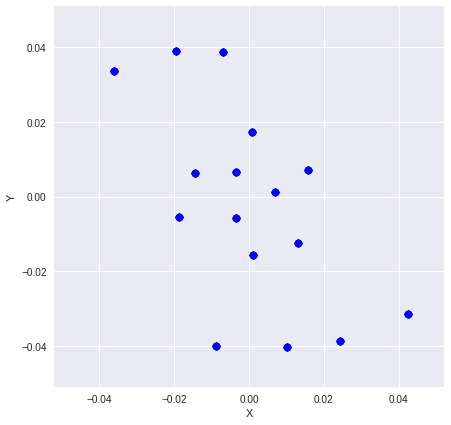

In [204]:
#=====================================================#
# Visualization
#=====================================================#
constellation = sess.run(X, feed_dict={X_tilde: training_set})
x = constellation[:, 0]
y = constellation[:, 1]

# plotting
fig=plt.figure(figsize=(7, 7))
ax = fig.add_subplot(2, 1, 1)
plt.plot(totalloss)
plt.xlabel('iteration')
plt.ylabel('loss')

fig = plt.figure(figsize=(7, 7))
ax1 = fig.add_subplot(111)
plt.xlabel('X')
plt.ylabel('Y')
ax1.scatter(x, y, c='b', marker='o')
plt.axis('equal')
xmax = max(abs(x))
ymax = max(abs(y))
max_axis = 1.2 * max(xmax, ymax)
plt.xlim(-max_axis, max_axis)
plt.ylim(-max_axis, max_axis)
plt.show()